In [1]:
The following notebook is a mirror of the R code used to complete my first and only submission for the Kaggle Titanic
competition. The following approach relied on a hypothesis testing model based on theoretical variable construction
rather than on extensive EDA. The goal was to quickly and efficiently execute a simple and computationally thifty
model that still demonstrated a high level of predictive validity. In addition, the intention was to create a machine
learning model that was easily interpretable and that was as simple as possible while maintaining strong performance.

Recursive partitioning (rpart) was selected as the machine learning algorithm of choice given 1) a desire for a high level
of interpretability and replicability and 2) a desire to consider the missing data without the need for imputation.

ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected symbol
1: The following
        ^


In [4]:
##Start By Loading Appropriate Datasets
library(readr)
train <- read_csv("C:/Users/samwk/Desktop/FNF Research Consulting/Kaggle Comps/Titanic/train.csv")
test <- read_csv("C:/Users/samwk/Desktop/FNF Research Consulting/Kaggle Comps/Titanic/test.csv")

Parsed with column specification:
cols(
  PassengerId = col_double(),
  Survived = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)
Parsed with column specification:
cols(
  PassengerId = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)


In [5]:
##Take a quick look at the training dataset
head(train)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


In [6]:
##Loading base packages
library(tidyverse)
library(caret)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v ggplot2 3.1.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



In [ ]:
HYPOTHESIS 1
---------------------------------------------------------------------------------------------------------------------------
I hypothesize that the probability distribution of survival as it relates to age is "U-shaped". In other words, 
I think very young children were less likely to survive due to a lack of sufficient resilience to the arctic waters and 
that older (for the era) individuals were less likely to survive either because of the "women and children" mentality or 
due to a similar lack of resilience. 

In [7]:
##Creating dummy variable with hypothesized age ranges
train %>%
  mutate(Age_Dummy = Age) -> train

train$Age_Dummy[train$Age_Dummy <= 4] <- 1
train$Age_Dummy[train$Age_Dummy >=4.1 & train$Age_Dummy <=50] <- 2
train$Age_Dummy[train$Age_Dummy >=50.1] <- 3

In [8]:
##Checking counts to ensure meaningful sample sizes
train %>%
  count(Age_Dummy)

Age_Dummy,n
1,40
2,610
3,64
NA,177


In [9]:
##Dropping original age variable
train <- subset(train, select = -c(Age))

In [ ]:
HYPOTHESIS 2
---------------------------------------------------------------------------------------------------------------------------
I also suspect that while cabin location would have a meaningful impact on likelihood of survival, the general location 
(e.g. floor, front vs. back of ship) is more important the the precise location. As a result, the likelihood of 
survivability can most likely be attributed, to degree, to the "quadrant" of the ship where the passenger was staying. 
To add this hypothetical location to the model, the ships schematics were pulled from the following 
location: http://ssmaritime.com/Titanic-3.htm

In [10]:
##Separating Dummy data, dropping all but first column
train <- separate(train, 
                    col = Cabin, 
                    sep = " ", 
                    into = c("Cabin_1", "Cabin_2", "Cabin_3", "Cabin_4"))

subset(train, select = -c(Cabin_2:Cabin_4)) -> train

Warning message:
"Expected 4 pieces. Missing pieces filled with `NA` in 202 rows [2, 4, 7, 11, 12, 22, 24, 28, 32, 53, 55, 56, 62, 63, 67, 76, 89, 93, 97, 98, ...]."

In [11]:
##Separating letters and numbers into their own columns
train <- separate(train, 
                  col = Cabin_1, 
                  into = c("Cab_text", "Cab_num"), 
                  sep = "(?<=[A-Z])(?=[0-9])")

Warning message:
"Expected 2 pieces. Missing pieces filled with `NA` in 8 rows [76, 129, 293, 328, 340, 474, 700, 716]."

In [12]:
##Highest number in set is "148", this number is split into 2 for calculation. Creating dummy variables 
##(1 = A1:D74, 2 = A:75:D148, 3 = E1:T74, 4 = E75:T148)

train <- transform(train, Cab_num = as.numeric(Cab_num))

train <- train %>%
  mutate(Cabin_Dummy = case_when(Cab_text == "A" & Cab_num <= 74 | 
                                   Cab_text == "B" & Cab_num <= 74 |
                                   Cab_text == "C" & Cab_num <= 74 |
                                   Cab_text == "D" & Cab_num <= 74 ~ 1,
                                 Cab_text == "A" & Cab_num >= 75 | 
                                   Cab_text == "B" & Cab_num >= 75 |
                                   Cab_text == "C" & Cab_num >= 75 |
                                   Cab_text == "D" & Cab_num >= 75 ~ 2,
                                 Cab_text == "E" & Cab_num <= 74 | 
                                   Cab_text == "F" & Cab_num <= 74 |
                                   Cab_text == "G" & Cab_num <= 74 |
                                   Cab_text == "T" & Cab_num <= 74 ~ 3,
                                 Cab_text == "E" & Cab_num >= 75 | 
                                   Cab_text == "F" & Cab_num >= 75 |
                                   Cab_text == "G" & Cab_num >= 75 |
                                   Cab_text == "T" & Cab_num >= 75 ~ 4))

In [ ]:
HYPOTHESIS 3
---------------------------------------------------------------------------------------------------------------------------
I also hypothesize that only some of the variables are meaningful predictors of the probability that a passenger would 
survive. In order to ensure that the model constructed by the training dataset generalizes and is not overfit, before 
feeding variables to the model, I will run a simple logistic regression. This should allow me to evaluate the potential 
value of various factors. Only the non-unique variables and dummy variables will be added to this analysis.

In [13]:
##Transforming appropriate variables to factors

train <- transform(train, Survived = as.factor(Survived),
                   Pclass = as.factor(Pclass),
                   SibSp = as.factor(SibSp),
                   Parch = as.factor(Parch),
                   Embarked = as.factor(Embarked), 
                   Sex = as.factor(Sex), 
                   Age_Dummy = as.factor(Age_Dummy),
                   Cabin_Dummy = as.factor(Cabin_Dummy))

In [14]:
##Loading appropriate library, executing forward selection glm
install.packages("leaps")
library(leaps)

regsubsets(Survived ~ Pclass + Sex + SibSp + 
             Parch + Fare + Embarked + 
             Age_Dummy + Cabin_Dummy,
            weights = NULL,
            data = train,
            nvmax = NULL,
            method = "forward") -> Forward_Model

package 'leaps' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\samwk\AppData\Local\Temp\RtmpSoQrTT\downloaded_packages


Warning message:
"package 'leaps' was built under R version 3.6.3"Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"6  linear dependencies found"

Reordering variables and trying again:


Warning message in rval$lopt[] <- rval$vorder[rval$lopt]:
"number of items to replace is not a multiple of replacement length"

In [15]:
##Attempting to identify the strongest model
summary(Forward_Model) -> Final_Model_Summary

data.frame(
  R2 = Final_Model_Summary$rsq,
  Adj.R2 = Final_Model_Summary$adjr2,
  CP = Final_Model_Summary$cp,
  BIC = Final_Model_Summary$bic)

R2,Adj.R2,CP,BIC
0.2620531,0.2578120,-9.3990301,-43.142509
0.2807182,0.2724028,-11.5117426,-42.480909
0.2841720,0.2716867,-10.2727717,-38.157578
0.2884534,0.2718090,-9.2161281,-34.042899
0.2919043,0.2710780,-7.9765221,-29.728083
0.2948217,0.2697858,-6.6193541,-25.284234
0.2970839,0.2677957,-5.1178055,-20.679254
0.2998916,0.2663535,-3.7364548,-16.213179
0.3021451,0.2643096,-2.2330060,-11.610126
0.3049957,0.2628742,-0.8611053,-7.160030


In [ ]:
MACHINE LEARNING EXECUTION
---------------------------------------------------------------------------------------------------------------------------
Based on the results above, it appears that the following factors are the most salient predictors of passenger survival: 
Sex, Age, Class, Embarkation, and Cabin location. Therefore, these are the factors that will be used to execute the 
machine learning model and the remaining variables will be dropped. Based on the data types, I suspect that there is not 
full independence between the predictor variables (rules out Naive Bayes). Simple logistic regression is probably 
insufficient to identify the subtle overlap between the variables.Therefore, a decision tree model is likely the 
best approach. Specifically, recursive partitioning has been selected in order to account for missing data without the 
need for imputation and to ensure a high degree of replicability/generalizability.

In [16]:
##Preparing new dataset for machine learning
ML_Train <- subset(train, select = c(Survived, Pclass, Sex, 
                                     Embarked, Age_Dummy, Cabin_Dummy))

In [17]:
##Ensuring "Survived" is the appropriate data class
ML_Train <- transform(ML_Train, as.factor(Survived))

In [18]:
##Running ML Model
install.packages("rpart")
install.packages("e1071")
library(rpart)
library(e1071)

Titanic_Control <- trainControl(method = "cv", 
                                number = 5, 
                                verboseIter = T)

Titanic_ML <- train(Survived ~.,
                    data = ML_Train,
                    method = "rpart", 
                    na.action = na.rpart,
                    trControl = Titanic_Control)

package 'rpart' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rpart'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\samwk\anaconda3\envs\r-tutorial\Lib\R\library\00LOCK\rpart\libs\x64\rpart.dll to C:\Users\samwk\anaconda3\envs\r-tutorial\Lib\R\library\rpart\libs\x64\rpart.dll: Permission denied"Warning message:
"restored 'rpart'"


The downloaded binary packages are in
	C:\Users\samwk\AppData\Local\Temp\RtmpSoQrTT\downloaded_packages

  There is a binary version available but the source version is later:
      binary source needs_compilation
e1071  1.7-6  1.7-8              TRUE

  Binaries will be installed
package 'e1071' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\samwk\AppData\Local\Temp\RtmpSoQrTT\downloaded_packages


Warning message:
"package 'e1071' was built under R version 3.6.3"

+ Fold1: cp=0.005848 
- Fold1: cp=0.005848 
+ Fold2: cp=0.005848 
- Fold2: cp=0.005848 
+ Fold3: cp=0.005848 
- Fold3: cp=0.005848 
+ Fold4: cp=0.005848 
- Fold4: cp=0.005848 
+ Fold5: cp=0.005848 
- Fold5: cp=0.005848 
Aggregating results
Selecting tuning parameters
Fitting cp = 0.00585 on full training set


In [19]:
##Analyzing the model's accuracy in predicting the data
Titanic_ML

CART 

891 samples
  5 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 713, 713, 712, 713, 713 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa    
  0.005847953  0.8103007  0.5709849
  0.032163743  0.7945703  0.5435820
  0.444444444  0.7127927  0.3143713

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.005847953.

In [ ]:
Results suggest the model is approximately 81% accurate based on the data present. Although this accuracy is a little 
lower than ideal, it does suggest that the data are likely not OVERFIT. Therefore, this model will be executed
on the test dataset. In addition, the extremely low CP value suggests that the model is also "pithy" in nature and is
therefore highly replicable.

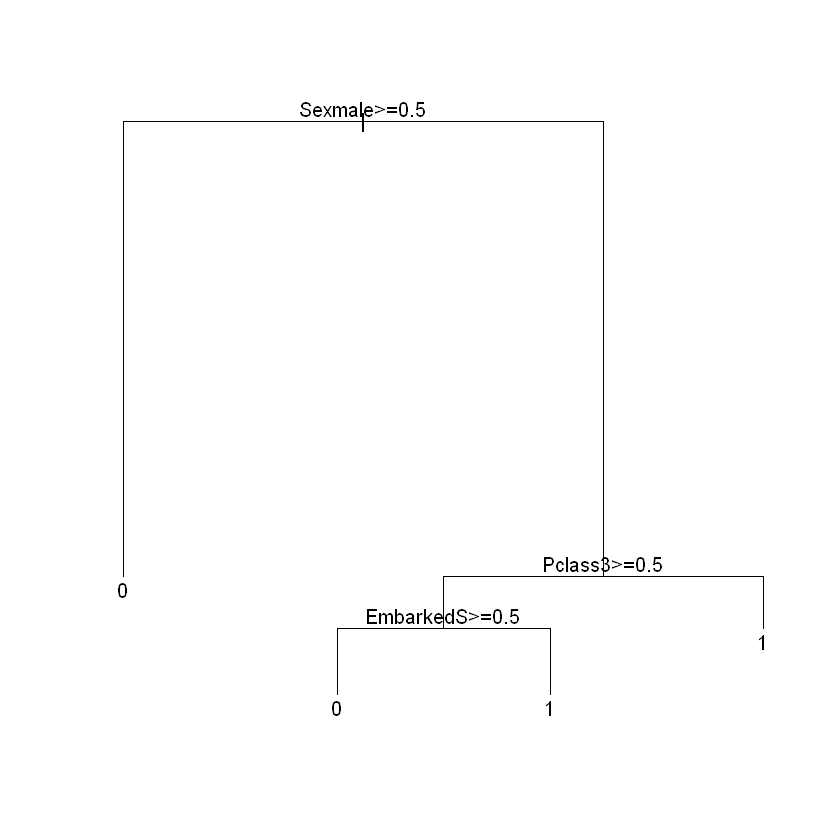

In [20]:
##Plotting recursive partitioning regression tree as final model

plot(Titanic_ML$finalModel)
text(Titanic_ML$finalModel)

In [ ]:
The decision tree illustration above demonstrates just how pithy this model really is. In this particular case, only
three of the factors were necessary to achieve 81% accurracy in fitting the training data. When applied to the test
set and submitted on Kaggle, these data produced a 77.51% accuracy in predicting survival rate.

Although these data suggest that this model may be somewhat underfit, the replicability, interpretability, and simplicity 
of this model are all strong. Fine tuning of this model may be achieved by adjusting hyperparameters or by employing a more
complex model altogether. However, it appears based on the Kaggle that submissions over 83% in accuracy are exceedingly 
rare. Therefore, the loss of replicability and simplicity may not outweigh the benefit gleaned by the additional 5% in 
predictive accuracy.